In [ ]:
import re, cv2, os, glob, random
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt


In [2]:
train_path = 'train'
test_path = 'test'

In [3]:
# Fungsi mengambil label dari nama file
def get_prefix(filename):
	match = re.match(r'^([A-Za-z]+)', filename)
	return match.group(1) if match else None

# Fungsi untuk memproses citra
def process_image(img_path):
	img = cv2.imread(img_path)

	if img is None:
		return None, None

	# Resize ke 256x256
	img = cv2.resize(img, (256, 256))

	# Normalisasi nilai pixel ke rentang [0, 1]
	img = img / 255.0

	filename = os.path.basename(img_path)
	label = get_prefix(filename)

	return img, label

# Fungsi untuk memuat dataset
def load_image_dataset(folder_path, max_samples):
	images, labels = [], []
	subfolders = ['jajusalatin', 'kramayana', 'samkok', 'sramayana']
	samples_per_folder = max_samples // len(subfolders)

	for subfolder in subfolders:
		subfolder_path = os.path.join(folder_path, subfolder)
		png_files = sorted(glob.glob(os.path.join(subfolder_path, '*.png')))[:samples_per_folder]

		# Gunakan tqdm untuk menampilkan progress bar
		for img_path in tqdm(png_files, desc=f"Loading {subfolder}", unit="image"):
			img, label = process_image(img_path)
			if img is not None and label is not None:
				images.append(img)
				labels.append(label)

	return np.array(images), np.array(labels)


# Load dataset
x_train, y_train = load_image_dataset(train_path, max_samples=80)
x_test, y_test = load_image_dataset(test_path, max_samples=20)

Loading kramayana: 100%|██████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 75.76image/s]


In [4]:
print(f"x_train shape => {x_train.shape} & x_test shape => {x_test.shape}")
print(f"x_train dtype => {x_train.dtype} & x_test dtype => {x_test.dtype}")

print()
print(f"train => {len(np.unique(y_train))} kelas & test => {len(np.unique(y_test))} kelas")
print()
# Cek normalisasi citra
print(f"Nilai pixel => min : {x_train.min()} & max => {x_train.max()}")

x_train shape => (80, 256, 256, 3) & x_test shape => (20, 256, 256, 3)
x_train dtype => float64 & x_test dtype => float64

train => 4 kelas & test => 4 kelas

Nilai pixel => min : 0.0 & max => 1.0


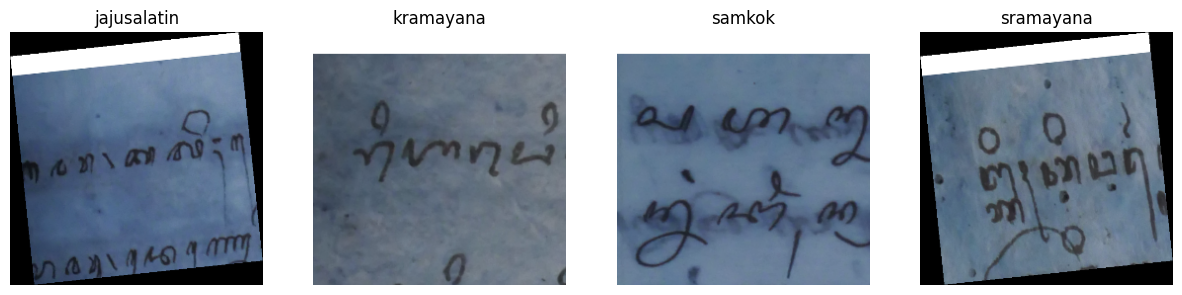

In [5]:
fig, axs = plt.subplots(1, 4, figsize=(15, 15))
for i, label in enumerate(np.unique(y_train)):
	axs[i].imshow(x_train[y_train == label][0])
	axs[i].set_title(label)
	axs[i].axis('off')
plt.show()

In [6]:
# Membuat kerusakakn sintesis

# Fungsi untuk menambahkan efek BERLUBANG (1 lubang besar)
def add_hole_damage(image):
	damaged = image.copy()
	h, w = damaged.shape[:2]

	# Tentukan titik dan radius lubang
	x, y = random.randint(50, w-50), random.randint(50, h-50)
	radius = random.randint(15, 30)

	# Ambil warna latar belakang (median pixel)
	bg_color = int(np.median(damaged))

	# Buat lubang dengan warna latar belakang
	cv2.circle(damaged, (x, y), radius, (bg_color,), -1)
	return damaged

# Fungsi untuk menambahkan efek Tinta Tembus
def add_ink_bleed(image):
	damaged = image.copy()
	h, w = damaged.shape[:2]
	x_offset = random.randint(10, 20)
	y_offset = random.randint(10, 20)
	mask = np.zeros_like(damaged)

	# Pindahkan aksara agar terlihat tembus
	mask[y_offset:h, x_offset:w] = damaged[0:h-y_offset, 0:w-x_offset]

	# Gabungkan dengan gambar asli (dengan opacity rendah)
	damaged = cv2.addWeighted(damaged, 0.8, mask, 0.2, 0)
	return damaged

# Fungsi untuk menambahkan efek Bercak
def add_stain_damage(image):
	damaged = image.copy()

	h, w = damaged.shape[:2]

	for _ in range(random.randint(1, 3)):  # Tambahkan 1-3 bercak
		# Tentukan posisi dan ukuran bercak
		x, y = random.randint(20, w-50), random.randint(20, h-50)
		size = random.randint(20, 50)

		# Tentukan warna bercak (abu-abu acak)
		gray_value = random.randint(100, 200) / 255.0  # Scale to 0.0 - 1.0

		# Buat bercak dengan distribusi normal dan Gaussian blur
		stain = np.random.normal(loc=gray_value, scale=0.08, size=(size, size, 3)).astype(np.float64)
		stain = cv2.GaussianBlur(stain, (5, 5), 0)  # Blur untuk tampilan alami
		stain = np.clip(stain, 0.0, 1.0).astype(np.float64)  # Pastikan nilai piksel valid

		# Pastikan ukuran bercak sesuai dengan area gambar
		if damaged[y:y+size, x:x+size].shape == stain.shape:
			# Gabungkan bercak dengan gambar asli
			blended = cv2.addWeighted(damaged[y:y+size, x:x+size].astype(np.float64), 0.2, stain, 0.8, 0)
			blended = np.clip(blended, 0.0, 1.0).astype(np.float64)
			damaged[y:y+size, x:x+size] = blended

	return damaged

# Fungsi untuk menambahkan efek TEKS HILANG (Blurring area tertentu)
def add_missing_text(image):
	damaged = image.copy()
	h, w, = damaged.shape[:2]

	for _ in range(random.randint(2, 4)):  # Hilangkan 2-4 area teks
		x, y = random.randint(20, w-160), random.randint(20, h-60)  # Area blur diperbesar
		width, height = random.randint(80, 160), random.randint(30, 60)  # Ukuran blur lebih besar

		blur_region = damaged[y:y+height, x:x+width]

		blur_region = cv2.GaussianBlur(blur_region, (19, 19), 0)  # Blur lebih intens, kernel size diganti menjadi (19, 19)

		damaged[y:y+height, x:x+width] = blur_region

	return damaged

In [7]:
num_samples = len(x_train) // 4

# Suffle dataset
indices = np.random.permutation(len(x_train))
x_train = x_train[indices]

# Bagi dataset train menjadi 4 bagian sesuai jenis kerusakan
train_hole = np.array([add_hole_damage(img) for img in tqdm(x_train[:num_samples], desc="Adding hole damage")])
train_bleed = np.array([add_ink_bleed(img) for img in tqdm(x_train[num_samples:num_samples*2], desc="Adding ink bleed")])
train_stain = np.array([add_stain_damage(img) for img in tqdm(x_train[num_samples*2:num_samples*3], desc="Adding fade")])
train_missing = np.array([add_missing_text(img) for img in tqdm(x_train[num_samples*3:num_samples*4], desc="Adding missing text")])

Adding missing text: 100%|████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 434.87it/s]


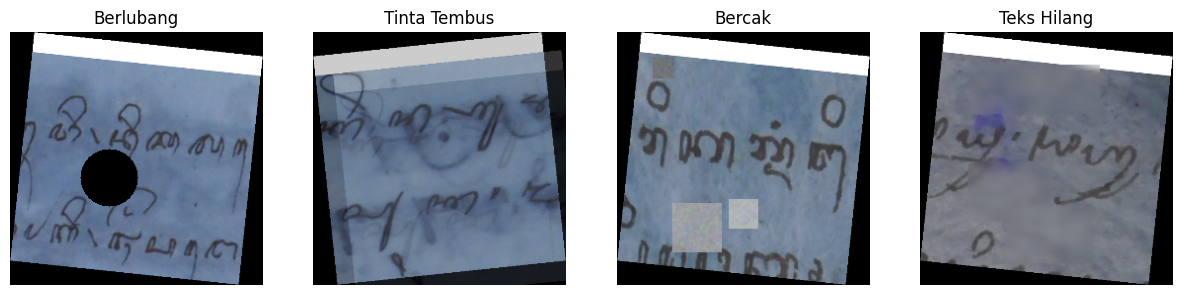

In [8]:
# Visualisasi satu contoh dari tiap jenis kerusakan
def visualize_damaged_images():
	fig, axes = plt.subplots(1, 4, figsize=(15, 5))

	axes[0].imshow(train_hole[15])
	axes[0].set_title("Berlubang")
	axes[0].axis('off')

	axes[1].imshow(train_bleed[15])
	axes[1].set_title("Tinta Tembus")
	axes[1].axis('off')

	axes[2].imshow(train_stain[15])
	axes[2].set_title("Bercak")
	axes[2].axis('off')

	axes[3].imshow(train_missing[15])
	axes[3].set_title("Teks Hilang")
	axes[3].axis('off')

	plt.show()

# Jalankan visualisasi
visualize_damaged_images()

In [9]:
train_data = x_train.copy()

# Gabungkan dataset kerusakan
train_damaged = np.concatenate([train_hole, train_bleed, train_stain, train_missing], axis=0)

# cek shape dan dtype dataset
print(f"train_damaged shape => {train_damaged.shape}")
print(f"train_damaged dtype => {train_damaged.dtype}")

# Gabungkan label
train_labels = np.concatenate([y_train[:num_samples], y_train[num_samples:num_samples*2], 
                               y_train[num_samples*2:num_samples*3], y_train[num_samples*3:num_samples*4]], axis=0)

# cek jumlah kelas
print(f"Jumlah kelas => {len(np.unique(train_labels))}")

train_damaged shape => (80, 256, 256, 3)
train_damaged dtype => float64
Jumlah kelas => 4


In [10]:
# Normalisasi dataset
train_damaged = train_damaged.astype(np.float32)
train_data = train_data.astype(np.float32)

# Normalisasi nilai pixel ke rentang [-1, 1]
train_damaged = (train_damaged - 0.5) / 0.5
train_data = (train_data - 0.5) / 0.5

# Mengubah channel citra dari 3 menjadi 1 jika perlu
train_data = np.array([cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) for img in train_data])
train_data = np.expand_dims(train_data, axis=-1)

train_damaged = np.array([cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) for img in train_damaged])
train_damaged = np.expand_dims(train_damaged, axis=-1)

train_damaged shape => (80, 256, 256, 1) & train_data shape => (80, 256, 256, 1)


In [13]:
print(f"train_damaged shape => {train_damaged.shape} & train_data shape => {train_data.shape}")
print(f"train_damaged dtype => {train_damaged.dtype} & train_data dtype => {train_data.dtype}")
print()
print(f"Nilai pixel => min : {train_damaged.min()} & max => {train_damaged.max()}")

train_damaged shape => (80, 256, 256, 1) & train_data shape => (80, 256, 256, 1)
train_damaged dtype => float32 & train_data dtype => float32

Nilai pixel => min : -1.0 & max => 1.0


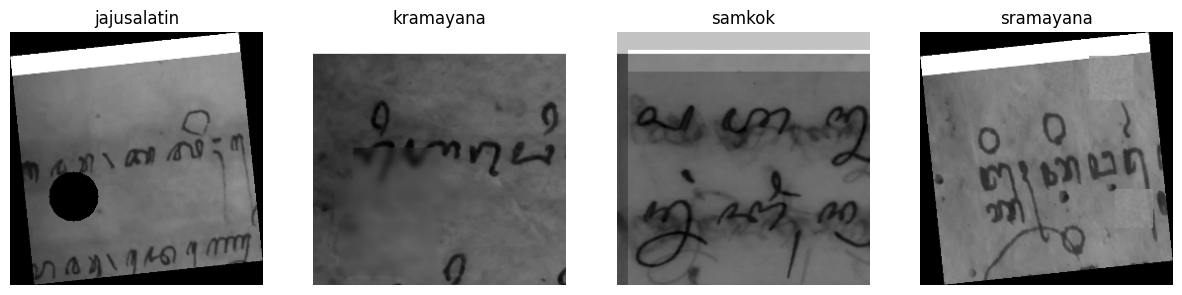

In [17]:
# Viasualisasi dataset
fig, axs = plt.subplots(1, 4, figsize=(15, 15))
for i, label in enumerate(np.unique(train_labels)):
	axs[i].imshow(train_damaged[train_labels == label][0], cmap='gray')
	axs[i].set_title(label)
	axs[i].axis('off')
plt.show()


In [11]:
import tensorflow as tf
print(tf.__version__)

import keras

from keras.layers import Conv2D, Conv2DTranspose, LeakyReLU, BatchNormalization, ReLU, Input, Dropout, Concatenate
from keras.layers import LayerNormalization, Activation, Multiply, Add, Layer
from keras.models import Model
from keras.utils import plot_model

from keras import initializers, regularizers, constraints

2.17.0


In [12]:
# 🌟 Spectral Normalization Layer
class SpectralNormalization(tf.keras.layers.Wrapper):
    def __init__(self, layer, power_iterations=1, **kwargs):
        super(SpectralNormalization, self).__init__(layer, **kwargs)
        self.power_iterations = power_iterations

    def build(self, input_shape):
        self.layer.build(input_shape)
        self.kernel = self.layer.kernel
        self.u = self.add_weight(shape=(1, self.kernel.shape[-1]),
                                 initializer="random_normal",
                                 trainable=False,
                                 name="sn_u")

    def call(self, inputs, training=None):
        # Power Iteration for Spectral Normalization
        w_shape = self.kernel.shape.as_list()
        w = tf.reshape(self.kernel, [-1, w_shape[-1]])

        u = self.u
        for _ in range(self.power_iterations):
            v = tf.linalg.l2_normalize(tf.matmul(u, tf.transpose(w)))
            u = tf.linalg.l2_normalize(tf.matmul(v, w))

        sigma = tf.matmul(tf.matmul(v, w), tf.transpose(u))
        w_norm = w / sigma
        self.layer.kernel.assign(tf.reshape(w_norm, w_shape))
        self.u.assign(u)
        return self.layer(inputs, training=training)


# 🔥 Self-Attention Layer
class SelfAttention(tf.keras.layers.Layer):
    def __init__(self, filters):
        super(SelfAttention, self).__init__()
        self.filters = filters
        self.query = Conv2D(filters // 8, kernel_size=1, padding="same")
        self.key = Conv2D(filters // 8, kernel_size=1, padding="same")
        self.value = Conv2D(filters, kernel_size=1, padding="same")
        self.gamma = tf.Variable(initial_value=tf.zeros(1), trainable=True)

    def call(self, x):
        batch, height, width, channels = tf.shape(x)[0], tf.shape(x)[1], tf.shape(x)[2], x.shape[-1]
        q = tf.reshape(self.query(x), (batch, height * width, channels // 8))
        k = tf.reshape(self.key(x), (batch, height * width, channels // 8))
        v = tf.reshape(self.value(x), (batch, height * width, channels))

        attn = tf.nn.softmax(tf.matmul(q, k, transpose_b=True))
        attn_out = tf.matmul(attn, v)
        attn_out = tf.reshape(attn_out, (batch, height, width, channels))

        return self.gamma * attn_out + x


# 🌟 Encoder Block
def encoder_block(x, filters, apply_batchnorm=True):
    x = SpectralNormalization(Conv2D(filters, kernel_size=4, strides=2, padding="same", use_bias=False))(x)
    if apply_batchnorm:
        x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    return x


# 🌟 Decoder Block
def decoder_block(x, skip_input, filters, apply_dropout=False):
    x = SpectralNormalization(Conv2DTranspose(filters, kernel_size=4, strides=2, padding="same", use_bias=False))(x)
    x = BatchNormalization()(x)
    if apply_dropout:
        x = Dropout(0.5)(x)
    x = ReLU()(x)
    x = Concatenate()([x, skip_input])
    return x


# 🌟 U-Net Generator Model
def build_generator(input_shape=(256, 256, 1)):
    inputs = Input(shape=input_shape)

    # Encoder (Downsampling)
    e1 = encoder_block(inputs, 64, apply_batchnorm=False)
    e2 = encoder_block(e1, 128)
    e3 = encoder_block(e2, 256)
    e4 = encoder_block(e3, 512)
    e5 = encoder_block(e4, 512)
    e6 = encoder_block(e5, 512)
    e7 = encoder_block(e6, 512)

    # Bottleneck with Self-Attention
    b = encoder_block(e7, 512)
    b = SelfAttention(512)(b)

    # Decoder (Upsampling + Skip Connections)
    d1 = decoder_block(b, e7, 512, apply_dropout=True)
    d2 = decoder_block(d1, e6, 512, apply_dropout=True)
    d3 = decoder_block(d2, e5, 512, apply_dropout=True)
    d4 = decoder_block(d3, e4, 512)
    d5 = decoder_block(d4, e3, 256)
    d6 = decoder_block(d5, e2, 128)
    d7 = decoder_block(d6, e1, 64)

    outputs = SpectralNormalization(Conv2DTranspose(1, kernel_size=4, strides=2, padding="same", activation="tanh"))(d7)

    return Model(inputs, outputs, name="U-Net_Generator")


# 🛠 Build Model
generator = build_generator()
generator.summary()

Model: "U-Net_Generator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)      │ (None, 256, 256, 1)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ spectral_normalization        │ (None, 128, 128, 64)      │           1,088 │ input_layer[0][0]          │
│ (SpectralNormalization)       │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ leaky_re_lu (LeakyReLU)       │ (None, 128, 128, 64)      │               0 │ spectral_normalization[0]… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ spectral_normalization_1      │ (None, 64, 64, 128)       │         131,200 │ leaky_re_lu[0][0]          │
│ (SpectralNormalization)       │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization           │ (None, 64, 64, 128)       │             512 │ spectral_normalization_1[… │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ leaky_re_lu_1 (LeakyReLU)     │ (None, 64, 64, 128)       │               0 │ batch_normalization[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ spectral_normalization_2      │ (None, 32, 32, 256)       │         524,544 │ leaky_re_lu_1[0][0]        │
│ (SpectralNormalization)       │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_1         │ (None, 32, 32, 256)       │           1,024 │ spectral_normalization_2[… │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ leaky_re_lu_2 (LeakyReLU)     │ (None, 32, 32, 256)       │               0 │ batch_normalization_1[0][… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ spectral_normalization_3      │ (None, 16, 16, 512)       │       2,097,664 │ leaky_re_lu_2[0][0]        │
│ (SpectralNormalization)       │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_2         │ (None, 16, 16, 512)       │           2,048 │ spectral_normalization_3[… │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ leaky_re_lu_3 (LeakyReLU)     │ (None, 16, 16, 512)       │               0 │ batch_normalization_2[0][… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ spectral_normalization_4      │ (None, 8, 8, 512)         │       4,194,816 │ leaky_re_lu_3[0][0]        │
│ (SpectralNormalization)       │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼───────────────

 Total params: 54,756,545 (208.88 MB)

 Trainable params: 54,737,153 (208.81 MB)

 Non-trainable params: 19,392 (75.75 KB)